# 4.4 Семинар: Классификация рукописных чисел полносвязанной сетью
---

## 1. Основные импорты + задание "зерна" для рандома

In [0]:
import torch
import random
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 2]

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## 2. Загрузка датасетов

In [32]:
import torchvision.datasets

print('Downloading datasets...')
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)
print('Done.')

Done.


## 3. Предобработка датасетов

Image shape: 28 x 28
Train size: 60000
Test size: 10000


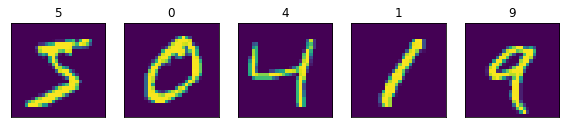

In [33]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

pic_h, pic_w = X_train[0].shape
print('Image shape: %d x %d'%(pic_h, pic_w))
print('Train size: %d\nTest size: %d'%(X_train.shape[0], X_test.shape[0]))

for i in range(5):
  plt.subplot(1,10,i + 1)
  plt.yticks([]), plt.xticks([])
  plt.title(y_train[i].item())
  plt.imshow(X_train[i, :, :])

  
X_train = X_train.reshape([-1, pic_h * pic_w]).float()
X_test = X_test.reshape([-1, pic_h * pic_w]).float()

## 4. Создание нейронной сети

In [0]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(pic_w * pic_h, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
      
mnist_net = MNISTNet(100)

## 5. Определение устройства для вычислений

In [0]:
pu_force = None
pu = pu_force if pu_force else \
      'cuda:0' if torch.cuda.is_available() else \
      'cpu'
device = torch.device(pu)

mnist_net = mnist_net.to(device)  

## 6. Определение функции потерь и алгоритма оптимизации

In [0]:
loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)
optimizer = torch.optim.Rprop(mnist_net.parameters(), lr=1.0e-3)

## 7. Обучение

In [0]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

t_time = time.time()
t_times = [0]

for epoch in range(200):
    order = np.random.permutation(len(X_train))
    
    train_losses = []
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        train_losses.append(loss_value.item())
        loss_value.backward()
        
        optimizer.step()

    t_times.append(time.time() - t_time)    
        
    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    train_loss_history.append(np.mean(train_losses))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    
t_time = time.time() - t_time
t_times = [t_times[i + 1] - t_times[i] for i in range(len(t_times) - 1)]

# Задачи

---



* **Постройте на одном графике loss для train и validation.**


Количество эпох: 200


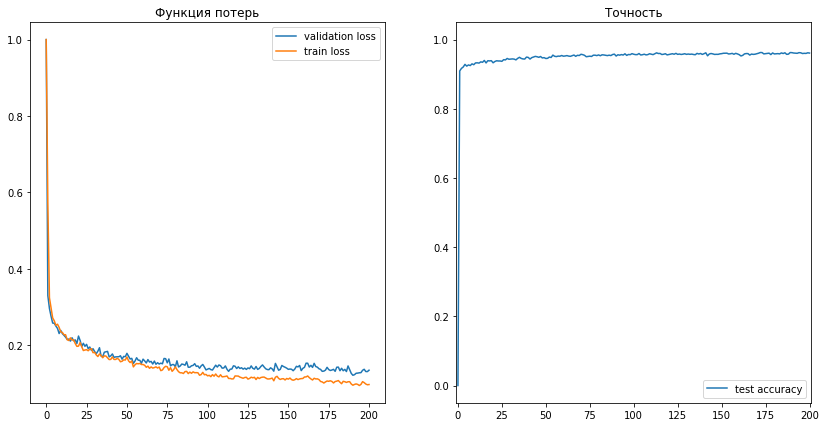

Итоговая ошибка на тренировочном датасете:   0.097644
Итоговая ошибка на валидационном датасете: 0.135144
Итоговая точность: 0.9610


In [8]:
def drawPlots():
  plt.rcParams['figure.figsize'] = [14, 7]
  print('Количество эпох: %d'%len(test_loss_history))

  fig, axs = plt.subplots(1, 2)
  ax, ax2 = axs
  plt.xlim(left=-1, right=len(test_loss_history) + 1)
  plt.ylim(bottom=-0.05, top=1.05)

  ax.plot([1]+test_loss_history, label='validation loss')
  ax.plot([1]+train_loss_history, label='train loss')
  legend = ax.legend(loc='upper right')
  ax.title.set_text('Функция потерь')

  ax2.plot([0]+test_accuracy_history, label='test accuracy')
  legend = ax2.legend(loc='lower right')
  ax2.title.set_text('Точность')

  plt.show()

  last_step = len(test_loss_history) - 1
  print("Итоговая ошибка на тренировочном датасете: \
  %f\nИтоговая ошибка на валидационном датасете: %f" %
        (train_loss_history[last_step], test_loss_history[last_step]))
  print("Итоговая точность: %f"% test_accuracy_history[last_step])
  
drawPlots()

* **Правда ли, что loss на train и validation падает одинаково быстро и выходит на одинаковое значение, или же у нас есть переобучение?**

Из графиков выше видно, что ошибка на тренировочном датасете убывает немного быстрее, чем на валидационном. Итоговые значения разоичаются на 0.0375, что говорит о том, что модель почти не переобучается. 

* **Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации?**
 

In [9]:
print("Точность после 40 эпох: %f\nТочность после 200 эпох: %f" %
      (test_accuracy_history[39], test_accuracy_history[199]))

Точность после 40 эпох: 0.948400
Точность после 200 эпох: 0.961000


Прирост точности составляет 0.0126. Улучшение есть, хоть и незначительное.


* **Замерьте время вычисления 100 эпох на CPU и на GPU. Какое ускорение вы наблюдаете?**



In [20]:
print("GPU")
print("Общее время: %dc"%t_time)
print("Среднее время на эпоху: %dс"%np.mean(t_times))

GPU
Общее время: 118c
Среднее время на эпоху: 1с


Для запуска на CPU необходимо узатновить `pu_force = 'cpu'` в блоке 5 и перезапустить обучение.

In [9]:
print("CPU")
print("Общее время: %dc"%t_time)
print("Среднее время на эпоху: %dс"%np.mean(t_times))

CPU
Общее время: 267c
Среднее время на эпоху: 2с


По результатам замеров, прирост в скорости при вычислениях на GPU составил 224%.

* **Замедляет ли torch.backends.cudnn.deterministic = True обучение на практике? Если да, то насколько?**

Необходимо установить `torch.backends.cudnn.deterministic = False` в блоке 1 и перезапустить обучение.

In [9]:
print("GPU в недетерминированном режиме")
print("Общее время: %dc"%t_time)
print("Среднее время на эпоху: %dс"%np.mean(t_times))

GPU в недетерминированном режиме
Общее время: 116c
Среднее время на эпоху: 1с


В результате обучение заняло на 2 секунды меньше. Данная разгница вызвана погрешностью измерений, поэтому можно сказать, что `torch.backends.cudnn.deterministic = False` не замедлило вычисления.



* **Попробуйте разные методы градиентного спуска, которые были в лекции. Как выбор градиентного спуска влияет на accuracy?**

1. Оптимизатор Adam


Оптимизатор:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Количество эпох: 200


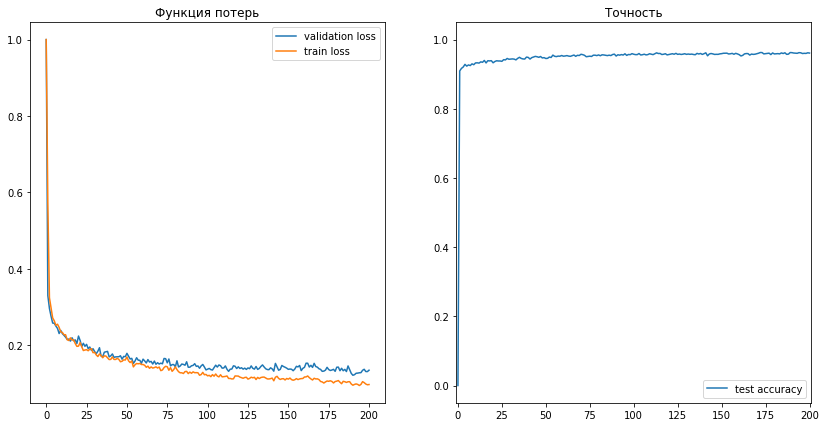

Итоговая ошибка на тренировочном датасете:   0.097644
Итоговая ошибка на валидационном датасете: 0.135144
Итоговая точность: 0.9610


In [9]:
adam_test_l, adam_train_l = test_loss_history, train_loss_history
adam_test_a = test_accuracy_history

print('Оптимизатор:\n', optimizer)
drawPlots()

2. Оптимизатор SGD

Оптимизатор:
 SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Количество эпох: 200


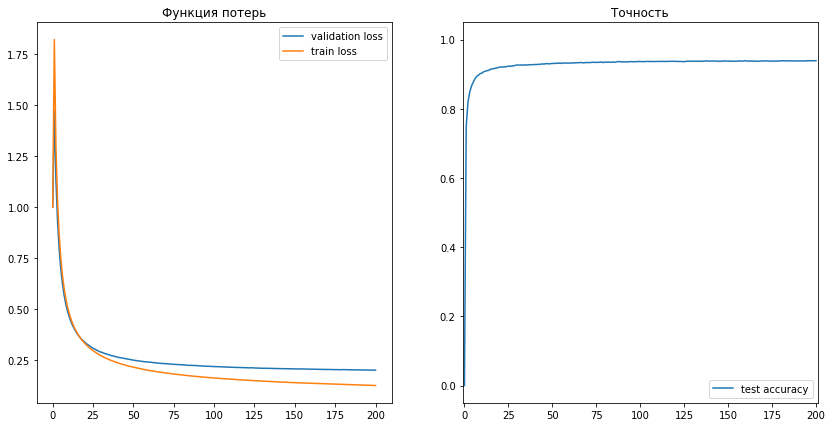

Итоговая ошибка на тренировочном датасете:   0.125651
Итоговая ошибка на валидационном датасете: 0.200833
Итоговая точность: 0.9390


In [17]:
sgd_test_l, sgd_train_l = test_loss_history, train_loss_history
sgd_test_a = test_accuracy_history

print('Оптимизатор:\n', optimizer)
drawPlots()

3. Оптимизатор SGD с импульсом

Оптимизатор:
 SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
Количество эпох: 200


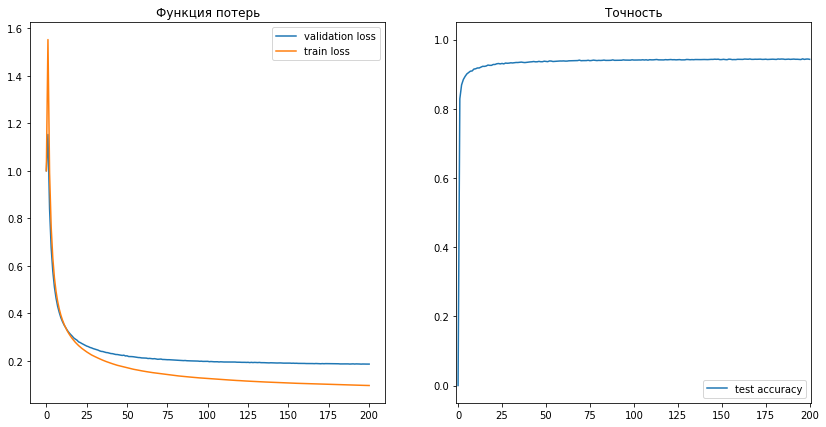

Итоговая ошибка на тренировочном датасете:   0.095389
Итоговая ошибка на валидационном датасете: 0.185586
Итоговая точность: 0.9429


In [22]:
sgdm_test_l, sgdm_train_l = test_loss_history, train_loss_history
sgdm_test_a = test_accuracy_history

print('Оптимизатор:\n', optimizer)
drawPlots()

4. Оптимизатор RMSprop

Оптимизатор:
 RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
Количество эпох: 200


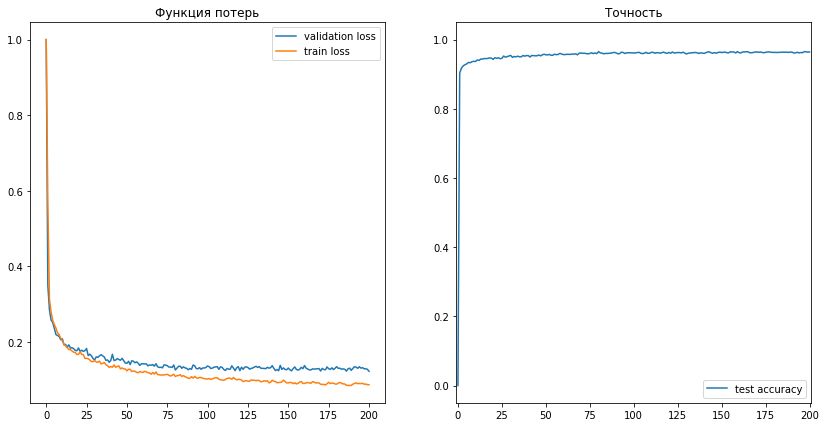

Итоговая ошибка на тренировочном датасете:   0.086272
Итоговая ошибка на валидационном датасете: 0.121834
Итоговая точность: 0.9641


In [30]:
rmsprop_test_l, rmsprop_train_l = test_loss_history, train_loss_history
rmsprop_test_a = test_accuracy_history

print('Оптимизатор:\n', optimizer)
drawPlots()

Сравнение

Количество эпох: 200


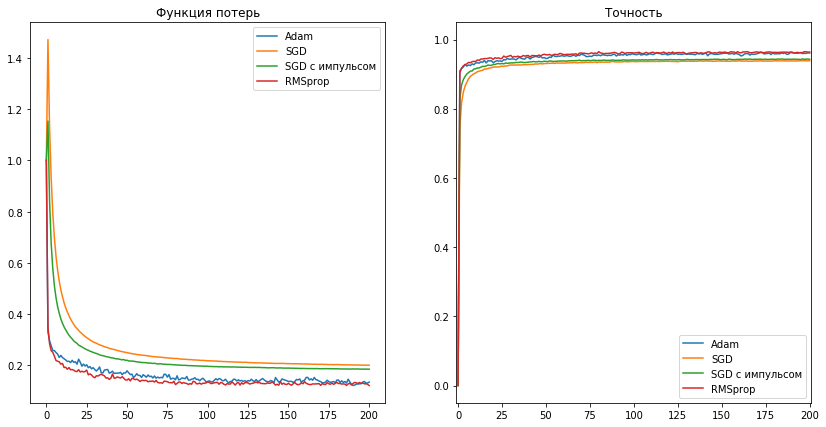

In [45]:
plt.rcParams['figure.figsize'] = [14, 7]
print('Количество эпох: %d'%len(test_loss_history))

fig, axs = plt.subplots(1, 2)
ax, ax2 = axs
plt.xlim(left=-1, right=len(test_loss_history) + 1)
plt.ylim(bottom=-0.05, top=1.05)

ax.plot([1]+adam_test_l, label='Adam')
ax.plot([1]+sgd_test_l, label='SGD')
ax.plot([1]+sgdm_test_l, label='SGD с импульсом')
ax.plot([1]+rmsprop_test_l, label='RMSprop')
legend = ax.legend(loc='upper right')
ax.title.set_text('Функция потерь')

ax2.plot([0]+adam_test_a, label='Adam')
ax2.plot([0]+sgd_test_a, label='SGD')
ax2.plot([0]+sgdm_test_a, label='SGD с импульсом')
ax2.plot([0]+rmsprop_test_a, label='RMSprop')
legend = ax2.legend(loc='lower right')
ax2.title.set_text('Точность')

plt.show()

Среди протестированных оптимизаторов, Adam и RMSprop с $lr=10^{-3}$ покалали наилучший результат (точность = 0.96), в то время как результаты SGD оказались немного хуже (точность = 0.94).